# Housing Prices
Unit 3 / Lesson 6 / Project 4

Using [this Kaggle data](https://www.kaggle.com/anthonypino/melbourne-housing-market) create a model to predict a house's value.
We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from sklearn.metrics import mean_squared_error

## Import data

In [2]:
# import data
PATH = ('assets\Melbourne_housing_FULL.csv')
raw_data = pd.read_csv(PATH, index_col=None)

df_raw = pd.DataFrame(raw_data)

df_raw.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


### Content & Acknowledgements
This data was scraped from publicly available results posted every week from Domain.com.au, I've cleaned it as best I can, now it's up to you to make data analysis magic. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale and distance from C.B.D.

....Now with extra data including including property size, land size and council area, you may need to change your code!

Some Key Details
Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

## EDA
Let's explore the data and get an idea of what we're working with.

In [ ]:
df_raw.info()

In [ ]:
df_raw.describe()

In [ ]:
# view price data
display(df_raw.Price.head())
df_raw.Price.dropna().hist()
plt.title('Price');

Let's see if we can log transform the Price data to create a distribution we can work with.

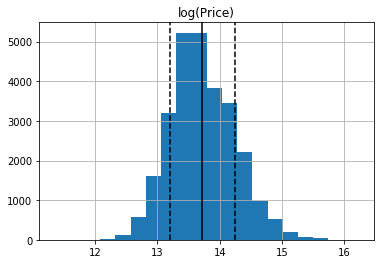

In [3]:
# log transform price data
df_raw['log_Price'] = np.log1p(df_raw.Price.dropna())

log_price_mean = df_raw['log_Price'].mean()
log_price_std = df_raw['log_Price'].std()

# view log(price) data
df_raw.log_Price.hist(bins=20)
plt.axvline((log_price_mean+log_price_std), color='k', linestyle='--')
plt.axvline((log_price_mean-log_price_std), color='k', linestyle='--')
plt.axvline(log_price_mean, color='k', linestyle='-')
plt.title('log(Price)');

That's much better.

## Data Cleaning

In [ ]:
# view missing data
display(df_raw.shape)
display(df_raw.dropna().shape)

It looks like our dataset has a ton of missing values, approximately 75%.
Let's see if we can clean some of this up by dropping unnecessary features filling in some NaNs.
We'll also have to work with our dtypes, we have 8 instances of dtype = object that we'll have to correct.

In [ ]:
# view features
df_raw.columns.values

# view sum of NaN values if
# all missing Price values are dropped
#df_raw.dropna(subset=['Price']).isna().sum()

# view sum of NaN values
df_raw.isna().sum()

It looks like most of our missing data is from the columns 'Price' (and consequentially 'log_Price'), 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuild', 'Lattitude', and 'Longitude'.
The rest of the columns with missing data should be easy to infer or input based on the rest of the data present.

The missing 'Price' data will be the most troublesome, as it is the variable we hope to predict. We could input the missing values with the median Price value, or the median Price value of homes in the similar class.
For example we could input the median price of all homes, or the median price homes with a similar number of rooms.
Either way, it will skew the data and our model.
We could drop the missing values, but we would loose ~20% of our dataset.

Let's start with filling in our other missing data and see what we're left with.
First, though, we'll define price ranges for low, median, and high priced homes.
These ranges will [hopefully] give us a more intuitive idea when inputting NaN values.

### Set categorical price values

In [4]:
# define 'high price' and 'low price' binary features
df_raw['high_price'] = np.where(
    df_raw['log_Price'] > (log_price_mean+log_price_std), 1, 0
)

df_raw['low_price'] = np.where(
    df_raw['log_Price'] < (log_price_mean-log_price_std), 1, 0
)

display(df_raw['high_price'].value_counts())
df_raw['low_price'].value_counts()

0    30493
1     4364
Name: high_price, dtype: int64

0    30741
1     4116
Name: low_price, dtype: int64

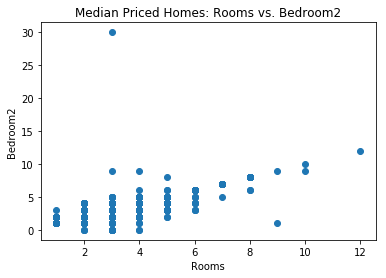

In [5]:
# high priced homes
#plt.scatter(df_raw['Rooms'].loc[df['high_price']==1],
#            df_raw['Bedroom2'].loc[df['high_price']==1])
#plt.xlabel('Rooms')
#plt.ylabel('Bedroom2')
#plt.title('High Priced Homes: Rooms vs. Bedroom2');

# low price homes
#plt.scatter(df_raw['Rooms'].loc[df['low_price']==1],
#            df_raw['Bedroom2'].loc[df['low_price']==1])
#plt.xlabel('Rooms')
#plt.ylabel('Bedroom2')
#plt.title('Low Priced Homes: Rooms vs. Bedroom2');

# median priced homes
plt.scatter(df_raw['Rooms'].loc[df_raw['low_price']==0].loc[df_raw['high_price']==0],
            df_raw['Bedroom2'].loc[df_raw['low_price']==0].loc[df_raw['high_price']==0])
plt.xlabel('Rooms')
plt.ylabel('Bedroom2')
plt.title('Median Priced Homes: Rooms vs. Bedroom2');

plt.show()

In [ ]:
#display(df_raw['Bedroom2'].isna().sum())
# calculate fillna values for high price, low price, and median priced homes
#high_price = df_raw['Bedroom2'].loc[df['high_price']==1].median() 
#low_price = df_raw['Bedroom2'].loc[df['low_price']==1].median()
#median_price = df_raw['Bedroom2'].loc[df['high_price']==0].loc[df['low_price']==0].median()

# fill NAs
#df_raw['Bedroom2'].loc[df['high_price']==1].fillna(high_price, inplace=True)
#df_raw['Bedroom2'].loc[df['low_price']==1].fillna(low_price, inplace=True)
#display(df_raw['Bedroom2'].isna().sum())
#df_raw['Bedroom2'].fillna(median_price, inplace=True)
#display(df_raw['Bedroom2'].isna().sum())

### Fill NaN values

In [6]:
# fill NaN values with median values for each column
cols = [ 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
        'BuildingArea', 'YearBuilt', 'Lattitude',
        'Longtitude', 'Distance', 'Postcode', 'Propertycount']
medians = []

for i in cols:
    if df_raw[i].dtype == 'float' or 'int':
        medians.append(df_raw[i].median())
        
for i in cols:
    for n in medians:
        df_raw[i].fillna(n, inplace=True)

In [7]:
# confirm we filled the NaN values
df_raw.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price            7610
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt           0
CouncilArea         3
Lattitude           0
Longtitude          0
Regionname          3
Propertycount       0
log_Price        7610
high_price          0
low_price           0
dtype: int64

In [8]:
# drop remaining NaN values
display(df_raw.shape)
df_na = df_raw.dropna()
df_na.shape

(34857, 24)

(27244, 24)

Now we've filled the NaN values we can and dropped the rest from the 'Price' column.
We maintained the original data set, so if we'd like to input missing Price values and rerun our models we can.

### Convert dtypes

In [9]:
# find our features with dtype == object
objects = []

for i in df_na.columns.values:
    if df_na[i].dtype == 'O':
        objects.append(str(i))

objects

['Suburb',
 'Address',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'CouncilArea',
 'Regionname']

In [10]:
df_na[objects]

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
1,Abbotsford,85 Turner St,h,S,Biggin,3/12/2016,Yarra City Council,Northern Metropolitan
2,Abbotsford,25 Bloomburg St,h,S,Biggin,4/02/2016,Yarra City Council,Northern Metropolitan
4,Abbotsford,5 Charles St,h,SP,Biggin,4/03/2017,Yarra City Council,Northern Metropolitan
5,Abbotsford,40 Federation La,h,PI,Biggin,4/03/2017,Yarra City Council,Northern Metropolitan
6,Abbotsford,55a Park St,h,VB,Nelson,4/06/2016,Yarra City Council,Northern Metropolitan
10,Abbotsford,129 Charles St,h,S,Jellis,7/05/2016,Yarra City Council,Northern Metropolitan
11,Abbotsford,124 Yarra St,h,S,Nelson,7/05/2016,Yarra City Council,Northern Metropolitan
14,Abbotsford,98 Charles St,h,S,Nelson,8/10/2016,Yarra City Council,Northern Metropolitan
15,Abbotsford,217 Langridge St,h,S,Jellis,8/10/2016,Yarra City Council,Northern Metropolitan
16,Abbotsford,18a Mollison St,t,S,Jellis,8/10/2016,Yarra City Council,Northern Metropolitan


In [11]:
for i in objects:
    print(i, len(df_na[i].unique()))

Suburb 344
Address 26748
Type 3
Method 5
SellerG 349
Date 78
CouncilArea 33
Regionname 8


The features 'Suburb', 'Address', and 'SellerG' have far too many unique values to be helpful.
So we will just drop those columns.

'Type', 'Method', and 'Regionname' we can convert with one-hot encoding to a new set of features.
If we do that, we can also drop 'CouncilArea' as it is a more specific (and likely directly correlated!) version of the 'Regionname' feature (for example, 'Yarra City Council' will only be in the 'Northen Metropolitan' region).

Lastly, we can convert 'Date' to a datetime format.

In [12]:
# drop features
drop_list = ['Suburb', 'Address', 'SellerG', 'CouncilArea']
df_na = df_na.drop(drop_list, axis=1)

df_na.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,log_Price,high_price,low_price
1,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,3.0,3.0,-37.7996,144.9984,Northern Metropolitan,4019.0,14.207553,0,0
2,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,Northern Metropolitan,4019.0,13.849913,0,0
4,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,Northern Metropolitan,4019.0,14.197366,0,0
5,3,h,850000.0,PI,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,3.0,3.0,-37.7969,144.9969,Northern Metropolitan,4019.0,13.652993,0,0
6,4,h,1600000.0,VB,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,Northern Metropolitan,4019.0,14.285515,1,0


In [13]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
# set sparse=False to return an array
cat_encoder = OneHotEncoder(sparse=False)
df_na_type_reshaped = df_na['Type'].values.reshape(-1,1)
df_na_type_1hot = cat_encoder.fit_transform(df_na_type_reshaped)
categories = cat_encoder.categories_
df_na_type_1hot = pd.DataFrame(df_na_type_1hot, columns=categories)

In [14]:
# concat 1hot DataFrame w/ df_na
# reset index of df_na and concat
df_na = df_na.reset_index().drop('index', axis=1)
df_na = pd.concat([df_na, df_na_type_1hot], axis=1)
df_na.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,Lattitude,Longtitude,Regionname,Propertycount,log_Price,high_price,low_price,"(h,)","(t,)","(u,)"
0,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,-37.7996,144.9984,Northern Metropolitan,4019.0,14.207553,0,0,1.0,0.0,0.0
1,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,-37.8079,144.9934,Northern Metropolitan,4019.0,13.849913,0,0,1.0,0.0,0.0
2,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,-37.8093,144.9944,Northern Metropolitan,4019.0,14.197366,0,0,1.0,0.0,0.0
3,3,h,850000.0,PI,4/03/2017,2.5,3067.0,3.0,2.0,1.0,...,-37.7969,144.9969,Northern Metropolitan,4019.0,13.652993,0,0,1.0,0.0,0.0
4,4,h,1600000.0,VB,4/06/2016,2.5,3067.0,3.0,1.0,2.0,...,-37.8072,144.9941,Northern Metropolitan,4019.0,14.285515,1,0,1.0,0.0,0.0


In [15]:
# one-hot encode 'Method' feature
df_na_meth_reshaped = df_na['Method'].values.reshape(-1,1)
df_na_meth_1hot = cat_encoder.fit_transform(df_na_meth_reshaped)
categories = cat_encoder.categories_
df_na_meth_1hot = pd.DataFrame(df_na_meth_1hot, columns=categories)

# concat 1hot DataFrame w/ df_na
df_na = pd.concat([df_na, df_na_meth_1hot], axis=1)
df_na.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,high_price,low_price,"(h,)","(t,)","(u,)","(PI,)","(S,)","(SA,)","(SP,)","(VB,)"
0,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,h,850000.0,PI,4/03/2017,2.5,3067.0,3.0,2.0,1.0,...,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,h,1600000.0,VB,4/06/2016,2.5,3067.0,3.0,1.0,2.0,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
# one-hot encode 'Regionname' feature
df_na_reg_reshaped = df_na['Regionname'].values.reshape(-1,1)
df_na_reg_1hot = cat_encoder.fit_transform(df_na_reg_reshaped)
categories = cat_encoder.categories_
df_na_reg_1hot = pd.DataFrame(df_na_reg_1hot, columns=categories)

# concat 1hot DataFrame w/ df_na
df_na = pd.concat([df_na, df_na_reg_1hot], axis=1)
df_na.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,"(SP,)","(VB,)","(Eastern Metropolitan,)","(Eastern Victoria,)","(Northern Metropolitan,)","(Northern Victoria,)","(South-Eastern Metropolitan,)","(Southern Metropolitan,)","(Western Metropolitan,)","(Western Victoria,)"
0,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,h,850000.0,PI,4/03/2017,2.5,3067.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,h,1600000.0,VB,4/06/2016,2.5,3067.0,3.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# drop features we used to for 1hot encoding
drop_list = ['Method', 'Type', 'Regionname']
df_na = df_na.drop(drop_list, axis=1)
df_na.head()

,Rooms,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,...,"(SP,)","(VB,)","(Eastern Metropolitan,)","(Eastern Victoria,)","(Northern Metropolitan,)","(Northern Victoria,)","(South-Eastern Metropolitan,)","(Southern Metropolitan,)","(Western Metropolitan,)","(Western Victoria,)"
0,2,1480000.0,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1035000.0,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1465000.0,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,850000.0,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1600000.0,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Convert to datetime

In [23]:
# convert Date feature to datetime
df_na['Date'].head()
df_na['Date'] = pd.to_datetime(df_na['Date'], errors='raise', dayfirst=1)
df_na['Date'].head()

0   2016-12-03
1   2016-02-04
2   2017-03-04
3   2017-03-04
4   2016-06-04
Name: Date, dtype: datetime64[ns]

In [32]:
# clean up columns from 1hot encoding
col_list = ['Rooms', 'Price', 'Date', 'Distance', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'Lattitude', 'Longtitude', 'Propertycount', 'log_Price',
       'high_price', 'low_price', 'h', 't', 'u', 'PI', 'S',
       'SA', 'SP', 'VB', 'Eastern Metropolitan',
       'Eastern Victoria', 'Northern Metropolitan',
       'Northern Victoria', 'South-Eastern Metropolitan',
       'Southern Metropolitan', 'Western Metropolitan',
       'Western Victoria']
df_na.columns = col_list

# store clean data
df_clean = df_na
df_clean.to_csv('assets\Melbourne_housing_FULL_clean.csv')

In [33]:
# check data
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27244 entries, 0 to 27243
Data columns (total 33 columns):
Rooms                         27244 non-null int64
Price                         27244 non-null float64
Date                          27244 non-null datetime64[ns]
Distance                      27244 non-null float64
Postcode                      27244 non-null float64
Bedroom2                      27244 non-null float64
Bathroom                      27244 non-null float64
Car                           27244 non-null float64
Landsize                      27244 non-null float64
BuildingArea                  27244 non-null float64
YearBuilt                     27244 non-null float64
Lattitude                     27244 non-null float64
Longtitude                    27244 non-null float64
Propertycount                 27244 non-null float64
log_Price                     27244 non-null float64
high_price                    27244 non-null int32
low_price                     27244 non-

Excellent! Our data is clean, we have no missing values, and our dtypes are correct.
Let's check our data for correlation and then it will be ready to model.

## Feature Selection

### Check for correlation.
First, let's define our data and target value.
Then we can check for correlation and drop any features with over 90% correlation.

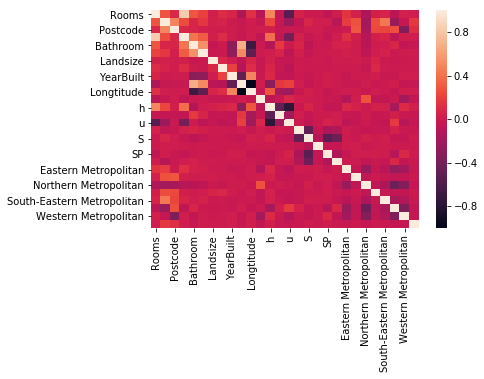

In [55]:
# define data and target
# drop our target value and derived values
# drop datetime as it likely won't help our model
drop_list = ['Price', 'log_Price', 'high_price', 'low_price', 'Date']
data = df_clean.drop(drop_list, axis=1)
target = df_clean['log_Price']

# plot a heatmap
sns.heatmap(data.corr());

In [52]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(data.shape)

# Drop correlated features 
for i in to_drop:
    data = data.drop(i, axis=1)

data.shape

(27244, 28)

(27244, 28)

It looks like our features aren't overly correlated.
Let's go ahead with modeling.

## Model Selection

In [ ]:
# define training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

# scale X_train values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

### Linear Regression

In [39]:
# determine which model to use
from sklearn.linear_model import LinearRegression
OLS = LinearRegression()
OLS.fit(X_train, y_train)
y_pred = OLS.predict(X_test)

#print(accuracy_score(y_test, y_pred))
#print(mean_squared_error(y_test, y_pred))

# Display.
print('Linear Regression')
print('\nR-squared training set:')
print(OLS.score(X_train, y_train))

#Store the parameter estimates.
#origparams = np.append(OLS.coef_, OLS.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(OLS.score(X_test, y_test))

Linear Regression

R-squared training set:
0.6843174917151899

R-squared test set:
0.681169443009009


### Linear Regression Scaled

In [41]:
# determine which model to use
OLS_scaled = LinearRegression()
OLS_scaled.fit(X_train_scaled, y_train)
y_pred = OLS_scaled.predict(X_test)

#print(accuracy_score(y_test, y_pred))
#print(mean_squared_error(y_test, y_pred))

# Display.
print('Scaled Linear Regression')
print('\nR-squared training set:')
print(OLS_scaled.score(X_train_scaled, y_train))

#Store the parameter estimates.
#origparams = np.append(OLS_scaled.coef_, OLS_scaled.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(OLS_scaled.score(X_test, y_test))

Scaled Linear Regression

R-squared training set:
0.6841883285258693

R-squared test set:
-1.0803283866788883e+24


### Random Forest Regression

In [43]:
# determine which model to use
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators=10)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

#print(accuracy_score(y_test, y_pred))
#print(mean_squared_error(y_test, y_pred))

# Display.
print('Random Forest Regressor')
print('\nR-squared training set:')
print(RF.score(X_train, y_train))

#Store the parameter estimates.
#origparams = np.append(RF.coef_, RF.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(RF.score(X_test, y_test))

Random Forest Regressor

R-squared training set:
0.9655266861680788

R-squared test set:
0.8477585142234566


### Random Forest Regressor Scaled

In [44]:
# determine which model to use
from sklearn.ensemble import RandomForestRegressor
RF_scaled = RandomForestRegressor(n_estimators=10)
RF_scaled.fit(X_train_scaled, y_train)
y_pred = RF_scaled.predict(X_test)

#print(accuracy_score(y_test, y_pred))
#print(mean_squared_error(y_test, y_pred))

# Display.
print('Scaled Random Forest Regressor')
print('\nR-squared training set:')
print(RF_scaled.score(X_train_scaled, y_train))

#Store the parameter estimates.
#origparams = np.append(RF_scaled.coef_, RF_scaled.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(RF_scaled.score(X_test, y_test))

Random Forest Regressor

R-squared training set:
0.9572781045409697

R-squared test set:
-0.1975876111070347


### Ridge Regression

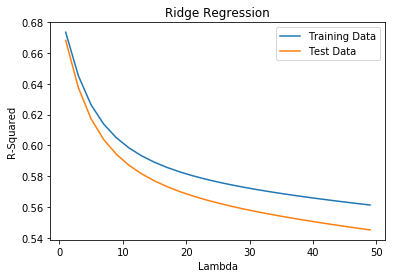

In [56]:
from sklearn.linear_model import Ridge

# define empty list
alphas = []
train_scores = []
test_scores = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridge = Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train, y_train)
    alphas.append(lambd)
    train_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))

plt.plot(alphas, train_scores, label='Training Data')
plt.plot(alphas, test_scores, label='Test Data')
plt.title('Ridge Regression')
plt.xlabel('Lambda')
plt.ylabel('R-Squared')
plt.legend()
plt.show();

In [57]:
# instantiate ridgeCV regression
from sklearn.linear_model import RidgeCV
alpha_list = range(1, 50, 2)
ridge = RidgeCV(alphas=alpha_list, cv=5)
ridge.fit(X_train, y_train)

# Display
print('Ridge Regression')
print('\nR-squared training set:')
print(ridge.score(X_train, y_train))

#Store the parameter estimates.
#origparams = np.append(ridge.coef_, ridge.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(ridge.score(X_test, y_test))

print('\nRidge regression alpha:')
print(ridge.alpha_)

Ridge Regression

R-squared training set:
0.6843165744448174

R-squared test set:
0.6811574428384257

Ridge regression alpha:
1


### Scaled Ridge Regression

In [58]:
# instantiate ridgeCV regression
alpha_list = range(1, 50, 2)
ridge_scaled = RidgeCV(alphas=alpha_list, cv=5)
ridge_scaled.fit(X_train_scaled, y_train)

# Display
print('Scaled Ridge Regression')
print('\nR-squared training set:')
print(ridge_scaled.score(X_train_scaled, y_train))

#Store the parameter estimates.
#origparams = np.append(ridge.coef_, ridge.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(ridge_scaled.score(X_test, y_test))

print('\nRidge regression alpha:')
print(ridge_scaled.alpha_)

Scaled Ridge Regression

R-squared training set:
0.6812467482606821

R-squared test set:
-13120.093486949409

Ridge regression alpha:
49


### Gradient Boosting Regressor

In [61]:
# determine which model to use
from sklearn.ensemble import GradientBoostingRegressor
GBRT = GradientBoostingRegressor(max_depth=2, n_estimators=120)
GBRT.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
         for y_pred in GBRT.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

GBRT_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
GBRT_best.fit(X_train, y_train)
y_pred = GBRT_best.predict(X_test)
#print(mean_squared_error(y_test, y_pred))

# Display
print('Gradient Boosting Regressor')
print('\nR-squared training set:')
print(GBRT_best.score(X_train, y_train))

#Store the parameter estimates.
#origparams = np.append(GBRT_best.coef_, GBRT_best.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(GBRT_best.score(X_test, y_test))

Gradient Boosting Regressor

R-squared training set:
0.7982561306411592

R-squared test set:
0.7937746798447424


### Gradient Boosting Regressor Scaled

In [63]:
# determine which model to use
GBRT_scaled = GradientBoostingRegressor(max_depth=2, n_estimators=120)
GBRT_scaled.fit(X_train_scaled, y_train)

errors = [mean_squared_error(y_test, y_pred)
         for y_pred in GBRT_scaled.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

GBRT_scaled_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
GBRT_scaled_best.fit(X_train_scaled, y_train)
y_pred = GBRT_scaled_best.predict(X_test)
#print(mean_squared_error(y_test, y_pred))

# Display
print('Scaled Gradient Boosting Regressor')
print('\nR-squared training set:')
print(GBRT_scaled_best.score(X_train_scaled, y_train))

#Store the parameter estimates.
#origparams = np.append(GBRT_scaled_best.coef_, GBRT_scaled_best.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nR-squared test set:')
print(GBRT_scaled_best.score(X_test, y_test))

Scaled Gradient Boosting Regressor

R-squared training set:
0.731532134024476

R-squared test set:
0.27161744267291377


## Fine Tune Model

In [ ]:
# define training and test set with new features
X_train, X_test, y_train, y_test = train_test_split(
    data_new, target, test_size=0.2, random_state=42)

In [ ]:
# import model
from sklearn.ensemble import GradientBoostingRegressor

# set default parameters
params = {'n_estimators':500,
          'max_depth':2,}

# instantiate model
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Grid search

In [ ]:
# import GridSearch
from sklearn.model_selection import GridSearchCV

# define our parameter ranges
param_grid = {
#    'learning_rate':[0.5, 0.25, 0.1, 0.05, 0.01],
#    'n_estimators':[50, 100, 200, 350, 500],
#    'subsample':np.linspace(0.1, 1.0, num=5, endpoint=True),
#    'min_samples_split':np.linspace(0.1, 1.0, num=5, endpoint=True),
#    'min_samples_leaf':np.linspace(0.1, 0.5, num=5, endpoint=True),
#    'max_depth':np.linspace(1, 32, num=5, endpoint=True),
#    'max_features':list(range(1,data.shape[1])),
#    'warm_start':[False, True],
#    'loss':['deviance', 'exponential'],
}

# Initialize and fit the model.
clf_best = GradientBoostingRegressor()
clf_best = GridSearchCV(clf_best, param_grid, cv=5)
clf_best.fit(X_train, y_train)

In [ ]:
clf_best.best_params_